## Import modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Reading dataset

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### Dataset description

client_id - идентификатор клиента  
education - уровень образования  
sex - пол заемщика  
age - возраст заемщика  
car - флаг наличия автомобиля  
car_type - флаг автомобиля иномарки  
decline_app_cnt - количество отказанных прошлых заявок  
good_work - флаг наличия “хорошей” работы  
bki_request_cnt - количество запросов в БКИ  
home_address - категоризатор домашнего адреса  
work_address - категоризатор рабочего адреса  
income - доход заемщика  
foreign_passport - наличие загранпаспорта  
sna - связь заемщика с клиентами банка  
first_time - давность наличия информации о заемщике  
score_bki - скоринговый балл по данным из БКИ  
region_rating - рейтинг региона  
app_date - дата подачи заявки  
default - флаг дефолта по кредиту

In [4]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = 0
data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [5]:
data[data['sample'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 36349 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  i

In [6]:
# Unique data by columns

data[data['sample'] == 1].nunique()

client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
sample                  1
default                 2
dtype: int64

In [7]:
# Empty cells by columns

data[data['sample'] == 1].isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [8]:
# Main metrics of dataset

data[data['sample'] == 1].describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.0,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,1.0,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.0,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,1.0,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,1.0,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.0,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.0,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.0,1.000000


In [9]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
59387,48011,25FEB2014,SCH,F,48,N,N,0,0,-2.353052,0,50,1,1,10000,2,3,N,1,0
18087,65059,14MAR2014,SCH,M,35,Y,N,0,0,-1.602110,3,80,2,3,35000,1,3,Y,0,0
84737,30737,06FEB2014,SCH,F,61,N,N,0,0,-1.747485,2,50,2,3,16000,3,2,N,1,0
10059,25137,31JAN2014,SCH,F,26,N,N,0,0,-2.406045,0,50,1,2,15000,2,2,N,0,0
104814,12208,20JAN2014,UGR,F,30,N,N,0,0,-2.080058,0,50,3,3,32000,1,3,N,1,0


## Function list

In [10]:
def outliers(col, col_name):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    outliers_count = pd.DataFrame(col[((col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR)))]).count()
    print(f'In column {outliers_count.index[0]} {outliers_count[0]} ouliers')


def percent_of_target(col1, col2):
    display(pd.crosstab(col1, col2, normalize='index'))

### Setup

In [11]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
le = LabelEncoder()
SEED = 42

### Numerical columns

#### Age

This column doen't have NaN. So, let's look at outliers and distribution by Default.

In [12]:
outliers(data[data['sample'] == 1]['age'], 'age')

In column age 0 ouliers


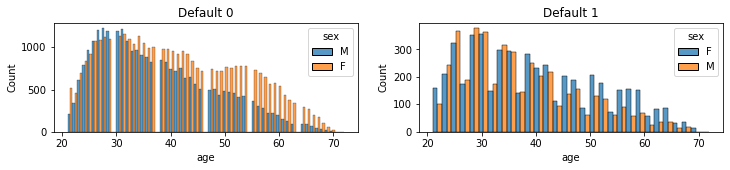

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
             x='age', hue='sex', multiple='dodge', ax=ax[0]).set_title('Default 0')
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
             x='age', hue='sex', multiple='dodge', ax=ax[1]).set_title('Default 1')
plt.show()

Intresting. Kredit for women more ofter had been approved. Denied the same.

In [14]:
print(f'Min Age is {data[data["sample"] == 1]["age"].min()}')
print(f'Max Age is {data[data["sample"] == 1]["age"].max()}')

Min Age is 21
Max Age is 72


Split it on categories by 5 years

In [15]:
cut_bins = list([x for x in range(19, 80, 5)])
cut_labels = list([x for x in range(len(cut_bins)-1)])
data['cat_age'] = pd.cut(data['age'], bins=cut_bins, labels=cut_labels).astype('int32')

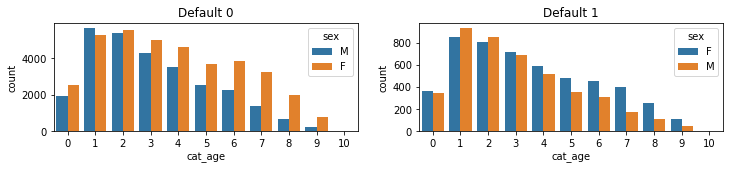

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='cat_age', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='cat_age', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

In [17]:
percent_of_target(data[data['sample'] == 1]['cat_age'], data[data['sample'] == 1]['default'])

default,0,1
cat_age,,
0,0.862229,0.137771
1,0.859879,0.140121
2,0.868963,0.131037
3,0.868765,0.131235
4,0.880069,0.119931
5,0.881624,0.118376
6,0.888581,0.111419
7,0.889210,0.110790
8,0.876908,0.123092


In [18]:
data['age'] = np.log(data['age'] + 1)

About equal distribution by categories over Default column.

#### score_bki

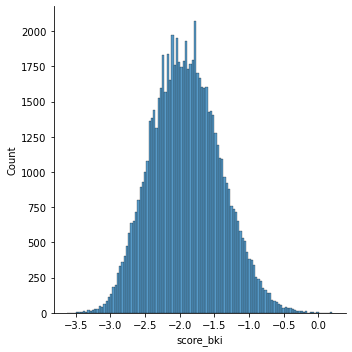

In [19]:
sns.displot(data[data['sample'] == 1]['score_bki'])
plt.show()

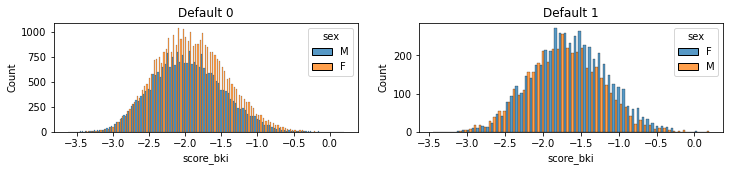

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
             x='score_bki', hue='sex', multiple='dodge', ax=ax[0]).set_title('Default 0')
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
             x='score_bki', hue='sex', multiple='dodge', ax=ax[1]).set_title('Default 1')
plt.show()

This column doen't have NaN. So, let's look at outliers and distribution by Default

In [21]:
outliers(data[data['sample'] == 1]['score_bki'], 'score_bki')

In column score_bki 351 ouliers


Let's make column to mark outliers.

In [22]:
Q1 = data[data['sample'] == 1]['score_bki'].quantile(0.25)
Q3 = data[data['sample'] == 1]['score_bki'].quantile(0.75)
IQR = Q3 - Q1
data['score_bki_outliers'] = ((data['sample'] == 1) & ((data['score_bki'] < (Q1 - 1.5 * IQR)) | (data['score_bki'] > (Q3 + 1.5 * IQR)))).astype('int32')

#### decline_app_cnt

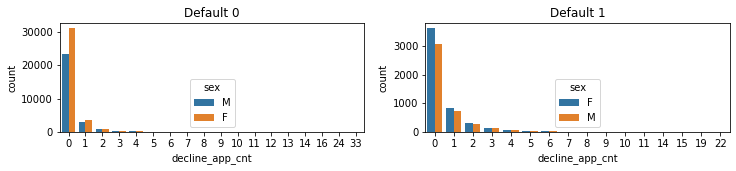

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='decline_app_cnt', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='decline_app_cnt', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

Count sum of each group

In [24]:
data[data['sample'] == 1]['decline_app_cnt'].value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

Let's group tails. Leave only 5 groups.

In [25]:
mask = (data['decline_app_cnt'] > 4)
data.loc[mask, 'decline_app_cnt'] = 4

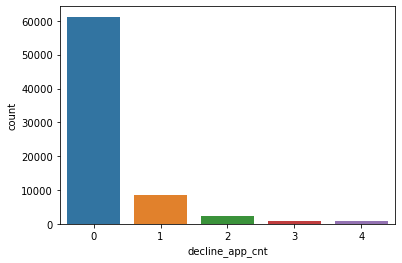

In [26]:
sns.countplot(x='decline_app_cnt', data=data[data['sample'] == 1])
plt.show()

In [27]:
percent_of_target(data[data['sample'] == 1]['decline_app_cnt'], data[data['sample'] == 1]['default'])

default,0,1
decline_app_cnt,,
0,0.890466,0.109534
1,0.812195,0.187805
2,0.756483,0.243517
3,0.726467,0.273533
4,0.703794,0.296206


#### bki_request_cnt

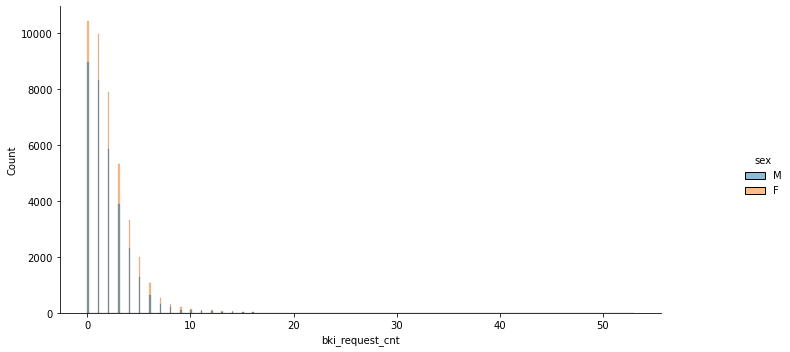

In [28]:
pl = sns.displot(x='bki_request_cnt', data=data[data['sample'] == 1], hue='sex')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

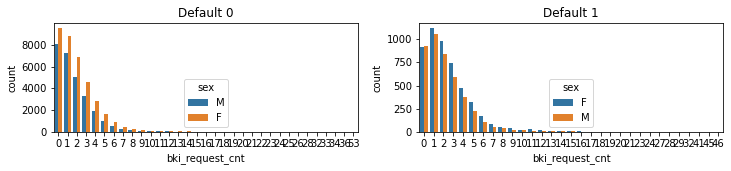

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='bki_request_cnt', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='bki_request_cnt', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

In [30]:
data[data['sample'] == 1]['bki_request_cnt'].value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
22        4
28        4
25        2
26        2
27        2
32        2
41        1
46        1
45        1
29        1
36        1
34        1
33        1
53        1
Name: bki_request_cnt, dtype: int64

In [31]:
mask1 = (data['bki_request_cnt'] > 18)
mask2 = (data['bki_request_cnt'].between(15, 18, inclusive=True))
mask3 = (data['bki_request_cnt'].between(12, 14, inclusive=True))
mask4 = (data['bki_request_cnt'].between(9, 11, inclusive=True))
mask5 = (data['bki_request_cnt'].between(6, 8, inclusive=True))
mask6 = (data['bki_request_cnt'].between(4, 5, inclusive=True))

data.loc[mask6, 'bki_request_cnt'] = 4
data.loc[mask5, 'bki_request_cnt'] = 5
data.loc[mask4, 'bki_request_cnt'] = 6
data.loc[mask3, 'bki_request_cnt'] = 7
data.loc[mask2, 'bki_request_cnt'] = 8
data.loc[mask1, 'bki_request_cnt'] = 9

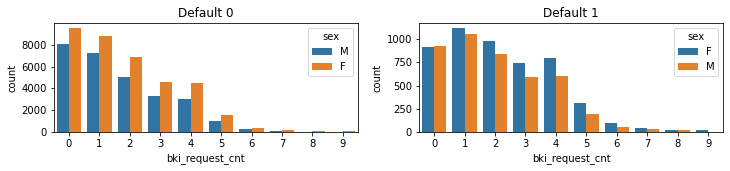

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='bki_request_cnt', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='bki_request_cnt', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

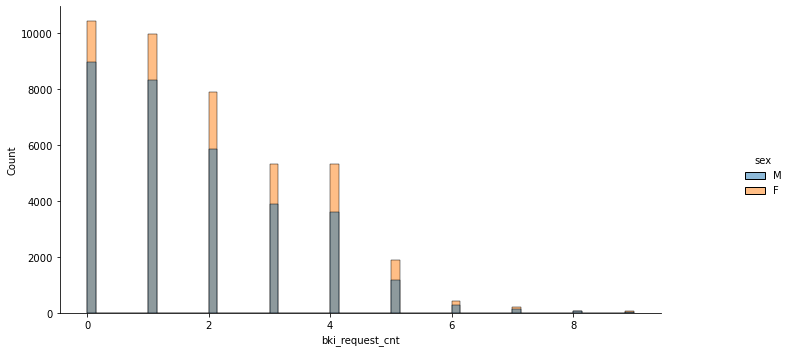

In [33]:
pl = sns.displot(x='bki_request_cnt', data=data[data['sample'] == 1], hue='sex')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

#### Income

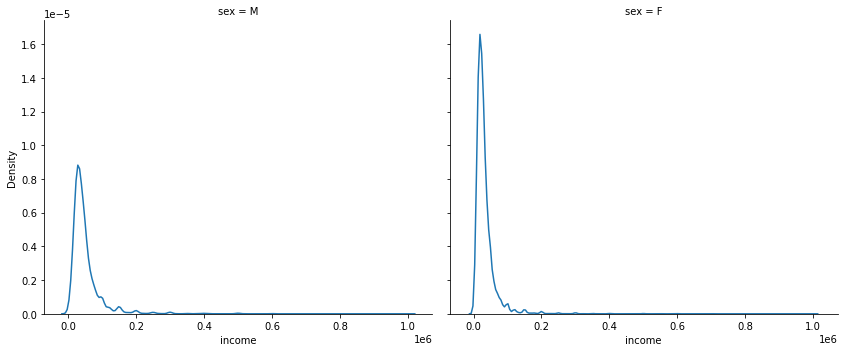

In [34]:
pl = sns.displot(data = data[data['sample'] == 1], x='income', col='sex', kind='kde')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

In [35]:
outliers(data[data['sample'] == 1]['income'], 'income')

In column income 4695 ouliers


In [36]:
Q1 = data[data['sample'] == 1]['income'].quantile(0.25)
Q3 = data[data['sample'] == 1]['income'].quantile(0.75)
IQR = Q3 - Q1
data['income_outliers'] = ((data['sample'] == 1) & ((data['income'] < (Q1 - 1.5 * IQR)) | (data['income'] > (Q3 + 1.5 * IQR)))).astype('int32')

25 quatile = 20000, 75 - 48000. Make cat column from income with step 5000. < 20000 - 0, > 48000 max cat

In [37]:
cut_income_bins = [0, 20000, 25000, 30000, 35000, 40000, 45000, 48000, 1000001]
cut_income_labels = [0, 1, 2, 3, 4, 5, 6, 7]

data['cat_income'] = pd.cut(data['income'], cut_income_bins, labels=cut_income_labels, right=False).astype('int32')

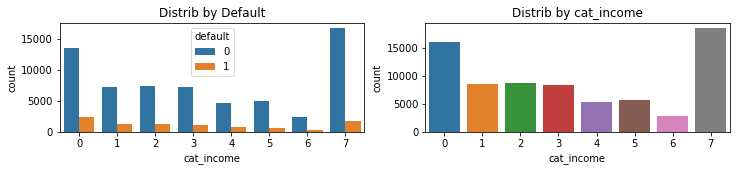

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='cat_income', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='cat_income', ax=ax[1]).set_title('Distrib by cat_income')
plt.show()

In [39]:
percent_of_target(data[data['sample'] == 1]['cat_income'], data[data['sample'] == 1]['default'])

default,0,1
cat_income,,
0,0.853437,0.146563
1,0.849900,0.150100
2,0.858661,0.141339
3,0.873969,0.126031
4,0.859730,0.140270
5,0.883493,0.116507
6,0.875133,0.124867
7,0.907273,0.092727


In [40]:
data['income'] = np.log(data['income'] + 1)

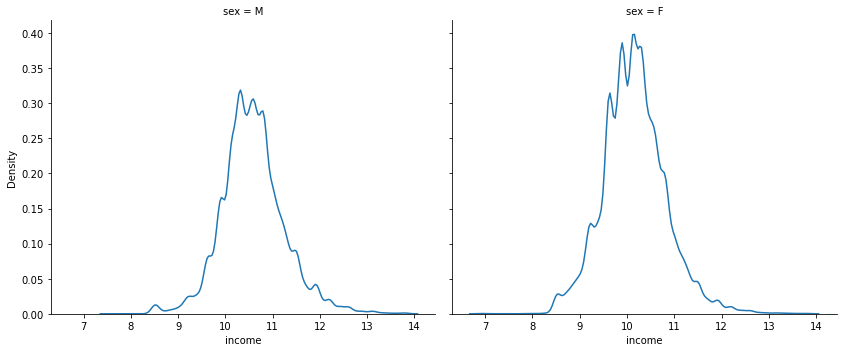

In [41]:
pl = sns.displot(data = data[data['sample'] == 1], x='income', col='sex', kind='kde')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

### Binary columns

#### sex

Convert from literal to numeric.

In [42]:
data['sex'] = (data['sex'] == 'M').astype('int32')

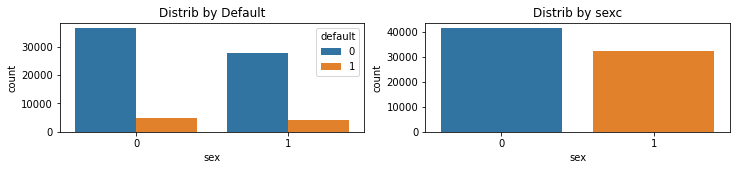

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='sex', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='sex', ax=ax[1]).set_title('Distrib by sexc')
plt.show()

#### car

Convert from literal to numeric

In [44]:
data['car'] = (data['car'] == 'Y').astype('int32')

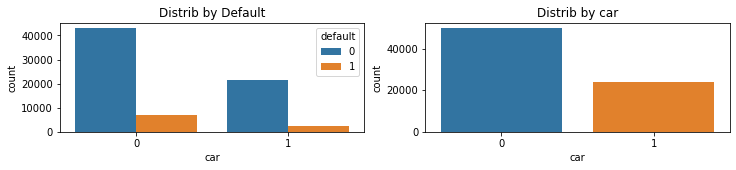

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='car', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='car', ax=ax[1]).set_title('Distrib by car')
plt.show()

#### car_type

Convert from literal to numeric

In [46]:
data['car_type'] = (data['car_type'] == 'Y').astype('int32')

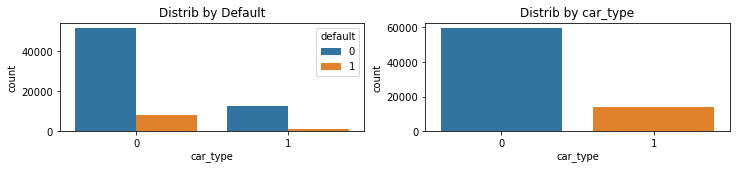

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='car_type', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='car_type', ax=ax[1]).set_title('Distrib by car_type')
plt.show()

#### good_work

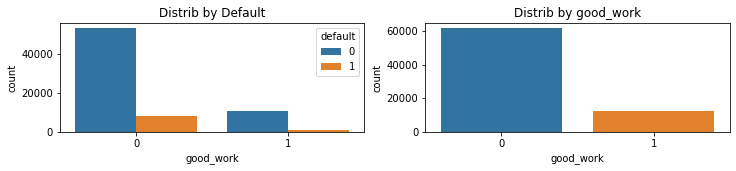

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='good_work', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='good_work', ax=ax[1]).set_title('Distrib by good_work')
plt.show()

#### foreign_passport

Convert from literal to numeric

In [49]:
data['foreign_passport'] = (data['foreign_passport'] == 'Y').astype('int32')

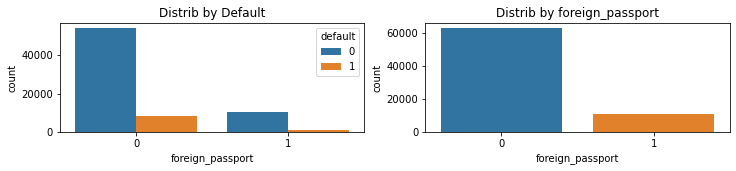

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='foreign_passport', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='foreign_passport', ax=ax[1]).set_title('Distrib by foreign_passport')
plt.show()

### Categorical columns

#### Education

In [51]:
data[(data['sample'] == 1)]['education'].value_counts(dropna=False)

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

This column has empty cells. Count them and fill by mode. There is only 307 in train. But first I make new column with marks of empty cells (like for outliers)

In [52]:
data['education_NaN'] = (data['education'].isna()).astype('int32')

In [53]:
data['education'].fillna('NOED', inplace=True)

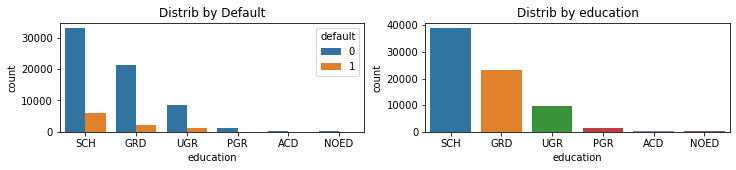

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='education', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='education', ax=ax[1]).set_title('Distrib by education')
plt.show()

In [55]:
percent_of_target(data[(data['sample'] == 1)]['education'], data[(data['sample'] == 1)]['default'])

default,0,1
education,,
ACD,0.958763,0.041237
GRD,0.909908,0.090092
NOED,0.885993,0.114007
PGR,0.935561,0.064439
SCH,0.849408,0.150592
UGR,0.868480,0.131520


Further I'll decide to do dummies or change cal names to numeric

#### first_time

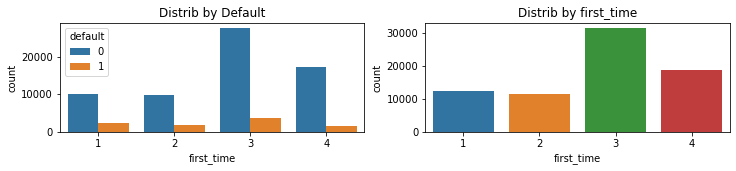

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='first_time', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='first_time', ax=ax[1]).set_title('Distrib by first_time')
plt.show()

In [57]:
percent_of_target(data[(data['sample'] == 1)]['first_time'], data[(data['sample'] == 1)]['default'])

default,0,1
first_time,,
1,0.813874,0.186126
2,0.844571,0.155429
3,0.879731,0.120269
4,0.917970,0.082030


#### sna

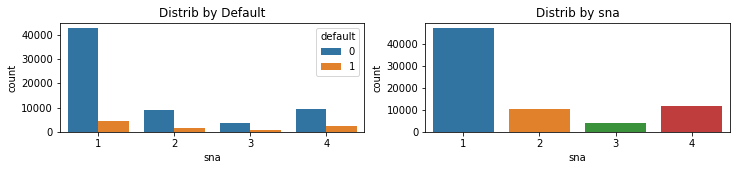

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='sna', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='sna', ax=ax[1]).set_title('Distrib by sna')
plt.show()

In [59]:
percent_of_target(data[(data['sample'] == 1)]['sna'], data[(data['sample'] == 1)]['default'])

default,0,1
sna,,
1,0.901799,0.098201
2,0.850179,0.149821
3,0.842348,0.157652
4,0.788493,0.211507


#### work_address

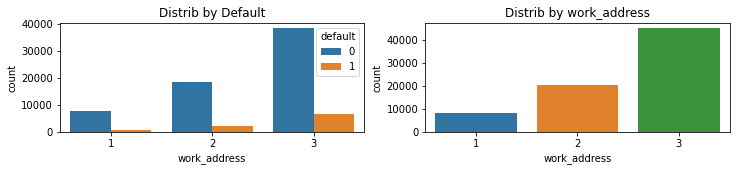

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='work_address', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='work_address', ax=ax[1]).set_title('Distrib by work_address')
plt.show()

In [61]:
percent_of_target(data[(data['sample'] == 1)]['work_address'], data[(data['sample'] == 1)]['default'])

default,0,1
work_address,,
1,0.925846,0.074154
2,0.897493,0.102507
3,0.852043,0.147957


#### home_address

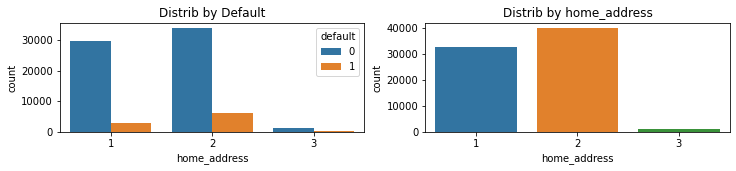

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='home_address', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='home_address', ax=ax[1]).set_title('Distrib by home_address')
plt.show()

In [63]:
percent_of_target(data[(data['sample'] == 1)]['home_address'], data[(data['sample'] == 1)]['default'])

default,0,1
home_address,,
1,0.907104,0.092896
2,0.844854,0.155146
3,0.883943,0.116057


#### region_rating

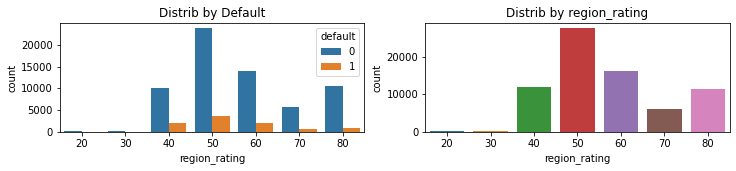

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1)], x='region_rating', hue='default', ax=ax[0]).set_title('Distrib by Default')
sns.countplot(data=data[(data['sample'] == 1)], x='region_rating', ax=ax[1]).set_title('Distrib by region_rating')
plt.show()

In [65]:
percent_of_target(data[(data['sample'] == 1)]['region_rating'], data[(data['sample'] == 1)]['default'])

default,0,1
region_rating,,
20,0.786408,0.213592
30,0.810000,0.190000
40,0.830298,0.169702
50,0.863859,0.136141
60,0.871166,0.128834
70,0.907566,0.092434
80,0.926846,0.073154


### Date column

In [66]:
data['app_date'] = pd.to_datetime(data['app_date'])

In [67]:
data['clients_count_by_day'] = data.groupby('app_date')['client_id'].transform('count')

### Dummies

In [73]:
dummies_lst = ['education', 'sex', 'car', 'car_type', 'good_work', 'region_rating', 'home_address', 
              'work_address', 'sna', 'first_time', 'foreign_passport']
dummies_data = pd.get_dummies(data[dummies_lst], columns=dummies_lst)
data = pd.concat([data, dummies_data], axis=1)

### Correcation check

In [ ]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(data[data['sample'] == 1].corr(), square=True,
              annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")
plt.show()

In [ ]:
cat_cols_new = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'cat_age', 'sna', 'work_address', 
               'home_address', 'region_rating', 'score_bki_outliers', 'income_outliers', 
               'cat_income', 'education_NaN', 'education_num_cat', 'carsex_num_cat']
num_cols_new = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'clients_count_by_day']
# cat_cols_new = ['car_type', 'good_work', 'foreign_passport', 'cat_age', 'sna', 
#                'home_address', 'region_rating', 'score_bki_outliers', 'income_outliers', 
#                'cat_income', 'education_NaN', 'education_num_cat', 'carsex_num_cat']
# num_cols_new = ['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'clients_count_by_day']

exp_cols = ['client_id', 'sex', 'car', 'work_address', 'app_date']

In [74]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default', 'cat_age',
       'score_bki_outliers', 'income_outliers', 'cat_income', 'education_NaN',
       'clients_count_by_day', 'education_ACD', 'education_GRD',
       'education_NOED', 'education_PGR', 'education_SCH', 'education_UGR',
       'sex_0', 'sex_1', 'car_0', 'car_1', 'car_type_0', 'car_type_1',
       'good_work_0', 'good_work_1', 'region_rating_20', 'region_rating_30',
       'region_rating_40', 'region_rating_50', 'region_rating_60',
       'region_rating_70', 'region_rating_80', 'home_address_1',
       'home_address_2', 'home_address_3', 'work_address_1', 'work_address_2',
       'work_address_3', 'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1',
       'first_time_2', 'first_time_3', 'first_tim

In [ ]:
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols_new], data[data['sample'] == 1]['default'])[0], index = num_cols_new)
imp_num.sort_values()

In [75]:
data['education_num_cat'] = le.fit_transform(data['education'])

In [76]:
data['carsex'] = data.apply(lambda x: 'YY' if (x['sex'] == 1 and x['car'] == 1) 
                            else 'YN' if (x['sex'] == 1 and x['car'] == 0) 
                            else 'NY' if (x['sex'] == 0 and x['car'] == 1) 
                            else 'NN', axis=1)

In [77]:
data['carsex_num_cat'] = le.fit_transform(data['carsex'])

In [ ]:
imp_cat = pd.Series(mutual_info_classif(data[data['sample'] == 1][cat_cols_new], data[data['sample'] == 1]['default'],
                                     discrete_features =True), index = cat_cols_new)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [ ]:
imp_cat = pd.Series(mutual_info_classif(data[data['sample'] == 1][cat_cols_new+num_cols_new], data[data['sample'] == 1]['default'],
                                     discrete_features='auto'), index=[cat_cols_new+num_cols_new])
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### normalizetion and balansing

In [78]:
object_columns = [s for s in data if (data[s].dtypes in ['object', 'datetime64[ns]'])]
data.drop(object_columns, axis = 1, inplace=True)

In [83]:
cols = data.drop(columns=['sample'], axis=1).columns.to_list()

In [84]:
train_data = data.query('sample == 1')[cols]
test_data = data.query('sample == 0')[cols].drop(['default'], axis=1)

In [85]:
train_data

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,cat_age,score_bki_outliers,income_outliers,cat_income,education_NaN,clients_count_by_day,education_ACD,education_GRD,education_NOED,education_PGR,education_SCH,education_UGR,sex_0,sex_1,car_0,car_1,car_type_0,car_type_1,good_work_0,good_work_1,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,foreign_passport_0,foreign_passport_1,education_num_cat,carsex_num_cat
36349,25905,1,4.143135,1,1,0,0,-2.008753,1,50,1,2,9.798183,4,1,0,0,8,0,0,0,0,794,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,4,3
36350,63161,0,4.094345,0,0,0,0,-1.532276,3,50,2,3,9.852247,4,1,0,0,7,0,0,0,0,1110,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,4,0
36351,25887,1,3.258097,1,0,2,0,-1.408142,1,80,1,2,10.308986,1,4,1,0,1,0,0,3,0,794,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,4,3
36352,16222,0,3.988984,0,0,0,0,-2.057471,2,50,2,3,9.210440,1,3,0,0,6,0,0,0,0,1060,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,4,0
36353,101655,1,3.891820,0,0,0,1,-1.244723,1,60,2,3,10.308986,1,4,1,0,5,0,0,3,0,981,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,0,3.828641,0,0,0,0,-1.792064,3,50,1,2,9.741027,4,4,0,0,5,0,0,0,0,1242,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0
110144,76821,1,3.737670,1,1,0,0,-2.058029,1,50,2,2,11.156265,1,4,0,0,4,0,0,7,0,1173,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,4,3
110145,103695,1,3.465736,0,0,0,0,-1.512635,4,80,2,3,10.714440,2,2,0,0,2,0,0,6,0,994,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,4,2
110146,861,0,3.401197,0,0,0,1,-1.479334,3,50,1,3,9.472782,2,3,0,1,1,0,0,0,0,447,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,4,0


In [86]:
y = train_data['default'].values

In [87]:
scaler=RobustScaler()

In [88]:
X = scaler.fit_transform(train_data.drop(columns='default', axis=1))

In [89]:
test_data = scaler.fit(test_data.values)

In [90]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=SEED)

In [91]:
sm = SMOTE(sampling_strategy='minority', random_state=SEED)

In [92]:
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

In [93]:
X_train.shape, X_train_oversampled.shape

((59039, 61), (102988, 61))

In [94]:
ros =  RandomOverSampler(sampling_strategy='minority', random_state=SEED)

In [95]:
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [107]:
lr = LogisticRegression(solver='liblinear', max_iter=1000)

In [108]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)
f1_score_basic = f1_score(y_valid, y_pred)
classification_report_basic = classification_report(y_valid, y_pred)

In [98]:
f1_score_basic

0.045501551189245086

In [118]:
print(classification_report_basic)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933
           1       0.41      0.02      0.05      1827

    accuracy                           0.87     14760
   macro avg       0.64      0.51      0.49     14760
weighted avg       0.82      0.87      0.82     14760



In [121]:
lr.fit(X_train_oversampled, y_train_oversampled)
y_pred_bal = lr.predict(X_valid)
f1_score_bal = f1_score(y_valid, y_pred_bal)
classification_report_bal = classification_report(y_valid, y_pred_bal)

In [112]:
f1_score_bal

0.33813536287034524

In [122]:
print(classification_report_bal)

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.73     14760



In [124]:
lr.fit(X_train_ros, y_train_ros)
y_pred_bal_ros = lr.predict(X_valid)
f1_score_bal_ros = f1_score(y_valid, y_pred_bal_ros)
classification_report_bal_ros = classification_report(y_valid, y_pred_bal_ros)

In [114]:
f1_score_bal_ros

0.34121941327565225

In [125]:
print(classification_report_bal_ros)

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.69      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



In [115]:
lr_we = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000)

In [126]:
lr_we.fit(X_train, y_train)
y_pred_we = lr.predict(X_valid)
f1_score_we = f1_score(y_valid, y_pred_we)
classification_report_we = classification_report(y_valid, y_pred_we)

In [127]:
f1_score_we

0.34121941327565225

In [128]:
print(classification_report_we)

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.69      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760

